In [103]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.svm import SVC,SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [104]:
pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [106]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx 
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

<h1>Extracting labels</h1>

In [109]:
path = "/content/AFLW2000"
mats = sorted(glob.glob(path + '/*.mat'))
labels = np.empty((0, 3))
for mat in mats :
  mat_file = sio.loadmat(mat)
  labels = np.append(labels , [mat_file["Pose_Para"][0][:3]] , axis = 0 )

In [110]:
labels = np.delete(labels , 1 , axis = 0)

<h1>Extracting features </h1>

In [128]:
def diff(x1,x2,y1,y2) :
  return np.sqrt((x2-x1)**2 + (y2-y1)**2)
  # return x1*x2*y1*y2
def normalize2(x_list,y_list) :
  distance = diff(x_list[10],x_list[152],y_list[10],y_list[152])
  # distance = 10
  x_list = (x_list - x_list[5])/distance
  y_list = (y_list - y_list[5])/distance
  return x_list , y_list

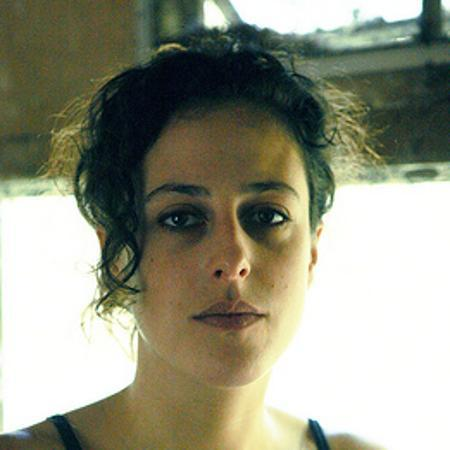

In [130]:
path = "/content/AFLW2000"

mats = sorted(glob.glob(path + '/*.mat'))
images = sorted(glob.glob(path + '/*.jpg'))
labels = np.empty((0, 3))


datax = np.empty((0, 468))
datay = np.empty((0, 468))
data = []
# processing the face to extract the landmark points (468 point) for each x,y,z
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    for ind , image in enumerate(images) :
        y_list = []
        x_list = []
        mat = image[:-4] + ".mat"
        image = cv2.imread(image)
        shape = image.shape 
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              ops = []
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # relative_x = int(x * shape[1])
                  # relative_y = int(y * shape[0])
                  # ops.extend([x,y])
                  x_list.append(x)
                  y_list.append(y)
          # data.extend(x_list)
          # data.extend(y_list)
          x_list = np.array(x_list)
          y_list = np.array(y_list)
          x_list , y_list = normalize2(x_list , y_list)
          datax = np.append(datax , [x_list] , axis = 0)
          datay = np.append(datay , [y_list] , axis = 0)
          data = np.hstack((datax,datay))
          mat_file = sio.loadmat(mat)
          labels = np.append(labels , [mat_file["Pose_Para"][0][:3]] , axis = 0 )
             
 
    cv2_imshow(image)

In [131]:
xpoints = datax
ypoints = datay

<h1>Data shape</h1>

In [132]:
print(len(x_list))
print(len(y_list))
print(datax.shape)
print(datay.shape)

468
468
(1853, 468)
(1853, 468)


In [133]:
labels.shape

(1853, 3)

<h1>splitting</h1>

In [134]:
x, x_test, y, y_test = train_test_split(data, labels, test_size=0.1, random_state=41)

<h1>Model</h1>

In [135]:
from sklearn.preprocessing import normalize
def train(x,y,x_test,y_test)  :
  svr = SVR(kernel='rbf', C=3 , degree=3 , epsilon = 0.1 , tol = 0.00001 )
  model = MultiOutputRegressor(svr)

  model.fit(x, y)
  predicted = model.predict(x)
  print("train error : " , mean_absolute_error(y,predicted))

  predicted = model.predict(x_test)
  # print("validation score :" ,r2_score( y_test , predicted))
  # print("validation score :" , model.score(x_test,y_test))
  # print("validation score :" , mean_squared_error(y_test,predicted))
  print("validation error :" , mean_absolute_error(y_test,predicted))

  return model

In [136]:
model = train(x,y,x_test,y_test)

train error :  0.07487871620849006
validation error : 0.13147684488509334


<h1>prediction</h1>

In [152]:
def get_mesh(path = None , image=None) :
  x_list = []  
  y_list = []
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      if path != None :
        image = cv2.imread(path)

      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            ops = []
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                # relative_x = int(x * shape[1])
                # relative_y = int(y * shape[0])
                # ops.extend([x,y])
                x_list.append(x)
                y_list.append(y)
            nose = (int(x_list[4]*shape[1]),int(y_list[4]*shape[0]))
            x_list = np.array(x_list)
            y_list = np.array(y_list)
            x_list , y_list = normalize2(x_list , y_list)

        ops = np.hstack((x_list,y_list))
                #cv2.putText(image, str(float(y)), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)
                #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        return (ops.reshape(1,-1) , nose)
      else : 
        print("can't get mesh")
        return False , False

def prediction( model , path=None ,image=None) :
  if path != None :
    image = cv2.imread(path)
    mesh , nose = get_mesh(path=path)
    if mesh is False :
      return image
  else :
    mesh , nose = get_mesh(image = image)
    if mesh is False :
      return image
  angels = model.predict(mesh).reshape(3,1)
  pitch = angels[0]
  yaw = angels[1]
  roll = angels[2]
  TDX = nose[0]
  TDY = nose[1]
  # print("tdx : " , TDX)
  # print("tdy : " , TDY)
  # print("x : " , mesh[0][8])
  # print("y : " , mesh[0][9])
  # print("image size : " , image.shape)
  # cv2.circle(image, (TDX , TDY), radius=1, color=(255, 255, 0), thickness=10)
  return draw_axis(image,pitch,yaw,roll,tdx=TDX , tdy=TDY)

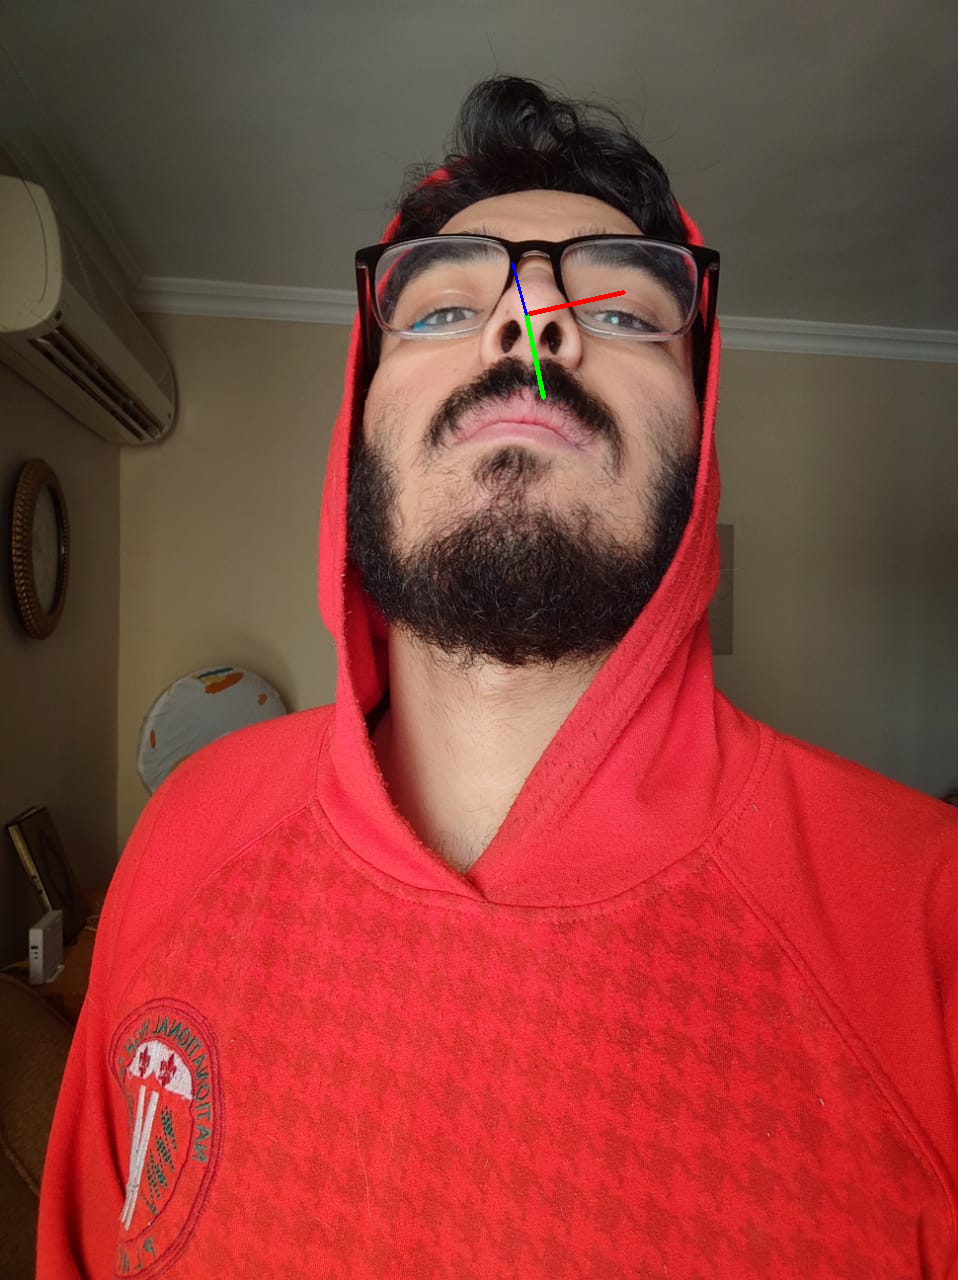

In [140]:
cv2_imshow(prediction(model ,path="/content/WhatsApp Image 2023-02-19 at 13.1d1.39.jpg")) 

<h1>importing video</h1>

In [173]:
cap = cv2.VideoCapture("/content/drive/MyDrive/finalfinal.mp4")

In [174]:
new = []
while cap.isOpened() :
  suc , im = cap.read()
  if suc is False :
    break
  new.append(prediction(model , image=im))
  # cv2_imshow(im)
  

In [175]:
w = new[0].shape[0]
h = new[0].shape[1]
result = cv2.VideoWriter('first5.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 24, (h,w))
for i in new :
  result.write(i)
result.release()